# Installing dependencies

In [1]:
!pip install -q torch transformers open_clip_torch accelerate bitsandbytes langchain langchain-community langchain-experimental sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille
!pip install matplotlib
!pip install plotly

# Importing all necessary libs

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path
from typing import Optional, List, Tuple
from tqdm.notebook import tqdm

import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
from PIL import Image

import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline, Pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs
%matplotlib inline

# Load dataset

In [2]:
df = pd.read_csv("llava_outputs_with_responses.csv")

In [3]:
df

,image_path,output,scene_graph,gpt_prompt,gpt_response
0,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg,"In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.","{'trash_can_1': [[728, 531, 816, 658]], 'wall_socket_1': [[546, 511, 639, 542]], 'wall_socket_2': [[0, 494, 31, 522]], 'cabinet_1': [[1137, 237, 1280, 681]], 'hinge_1': [[863, 215, 944, 243]], 'tricycle_1': [[0, 538, 209, 623]], 'cabinet_2': [[854, 223, 1280, 674]], 'knob_1': [[1128, 250, 1141, 262]], 'hinge_2': [[862, 262, 869, 340]], 'thermostat_1': [[23, 125, 49, 152]], 'refrigerator_1': [[855, 225, 1157, 673]], 'wheel_1': [[143, 553, 210, 622]], 'bulletin_board_1': [[60, 0, 816, 343]], 'knob_2': [[1175, 252, 1190, 275]]}","You are given with a JSON-like description of the scene. This description is a dictionary where the key is the class name and ID of the object, and value is the bounding box of the object in the source image. Based on this dictionary, you are asked to generate a graph-like description of the scene. You need to summarize spatial relationships between the objects on the scene. Be brief and precise, don't give introductory and conclusion words. Focus on the meaningful part of the response. Also ignore following classes: person, lightbulb. \n{'trash_can_1': [[728, 531, 816, 658]], 'wall_socket_1': [[546, 511, 639, 542]], 'wall_socket_2': [[0, 494, 31, 522]], 'cabinet_1': [[1137, 237, 1280, 681]], 'hinge_1': [[863, 215, 944, 243]], 'tricycle_1': [[0, 538, 209, 623]], 'cabinet_2': [[854, 223, 1280, 674]], 'knob_1': [[1128, 250, 1141, 262]], 'hinge_2': [[862, 262, 869, 340]], 'thermostat_1': [[23, 125, 49, 152]], 'refrigerator_1': [[855, 225, 1157, 673]], 'wheel_1': [[143, 553, 210, 622]], 'bulletin_board_1': [[60, 0, 816, 343]], 'knob_2': [[1175, 252, 1190, 275]]}","- Trash can is below the bulletin board and to the right of the tricycle.\n- Wall socket 1 is to the left of the trash can and below the bulletin board.\n- Wall socket 2 is to the left of the tricycle and below the bulletin board.\n- Cabinet 1 is to the right of the refrigerator and above the trash can.\n- Cabinet 2 is to the right of the refrigerator and above the trash can.\n- Hinge 1 is above the refrigerator and to the left of cabinet 1.\n- Tricycle is to the left of the trash can and below the bulletin board.\n- Refrigerator is to the left of cabinet 1 and cabinet 2.\n- Wheel is part of the tricycle and below the bulletin board.\n- Bulletin board is above the trash can, wall sockets, and tricycle.\n- Knob 1 is on cabinet 1.\n- Hinge 2 is on cabinet 2 and above the refrigerator.\n- Thermostat is above the tricycle and to the left of the bulletin board.\n- Knob 2 is on cabinet 2."
1,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00252.jpg,"The image shows an interior space that appears to be a corridor or hallway. The floor is covered with a dark gray carpet, and the walls are painted white. On the left side of the image, there is a white door with a black handle, which is partially visible. The door is closed.\n\nIn the background, there is a glass partition that separates the hallway from another room. The glass is transparent, allowing a view into the room beyond. The room beyond the glass partition has a modern design with a white ceiling and a large window that lets in natural light. The window is reflective, suggesting it might be a glass wall or a large glass panel.\n\nOn the right si

In [4]:
from pathlib import Path

# Функция для извлечения stem из пути
def extract_stem(image_path):
    return Path(image_path).stem

# Using'image_id' for more versatile usage
df['image_id'] = df['image_path'].apply(extract_stem)


In [5]:
df['combined'] = 'Image ID is ' + df['image_id'] + '.\nHere is the short description of it: \n' + df['output'] + "\nHere is the scene graph of it: \n" + df['gpt_response']
df['only_captions'] = 'Image ID is ' + df['image_id'] + '.\nHere is the short description of it: \n' + df['output']
df['only_graph'] = 'Image ID is ' + df['image_id'] + "\nHere is the scene graph of it: \n" + df['gpt_response']

In [6]:
# datasets for different contexts
ddf = df['combined']
ddf_c = df['only_captions']
ddf_g = df['only_graph']

In [7]:
ddf.loc[15]

'Image ID is 00627.\nHere is the short description of it: \nThe image shows an interior space that appears to be a lobby or waiting area. In the foreground, there is a large, white, rectangular box with text on it, which could be a sign or a piece of equipment. To the right of this box, there is a white couch with a curved backrest. The couch is positioned against a wall that has a red fire extinguisher mounted on it.\n\nIn the background, there is a glass partition with a patterned design, through which a doorway is visible. The doorway leads to another room with a white door and a circular window. The floor is carpeted, and there are several white squares on the carpet, which could be markers or indicators for some purpose.\n\nThe lighting in the room is bright, and the overall color scheme is neutral, with white and gray tones dominating the space. There are no people visible in the image. The style of the image is a standard, unfiltered photograph with no artistic effects applied.\

/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2722.32it/s]


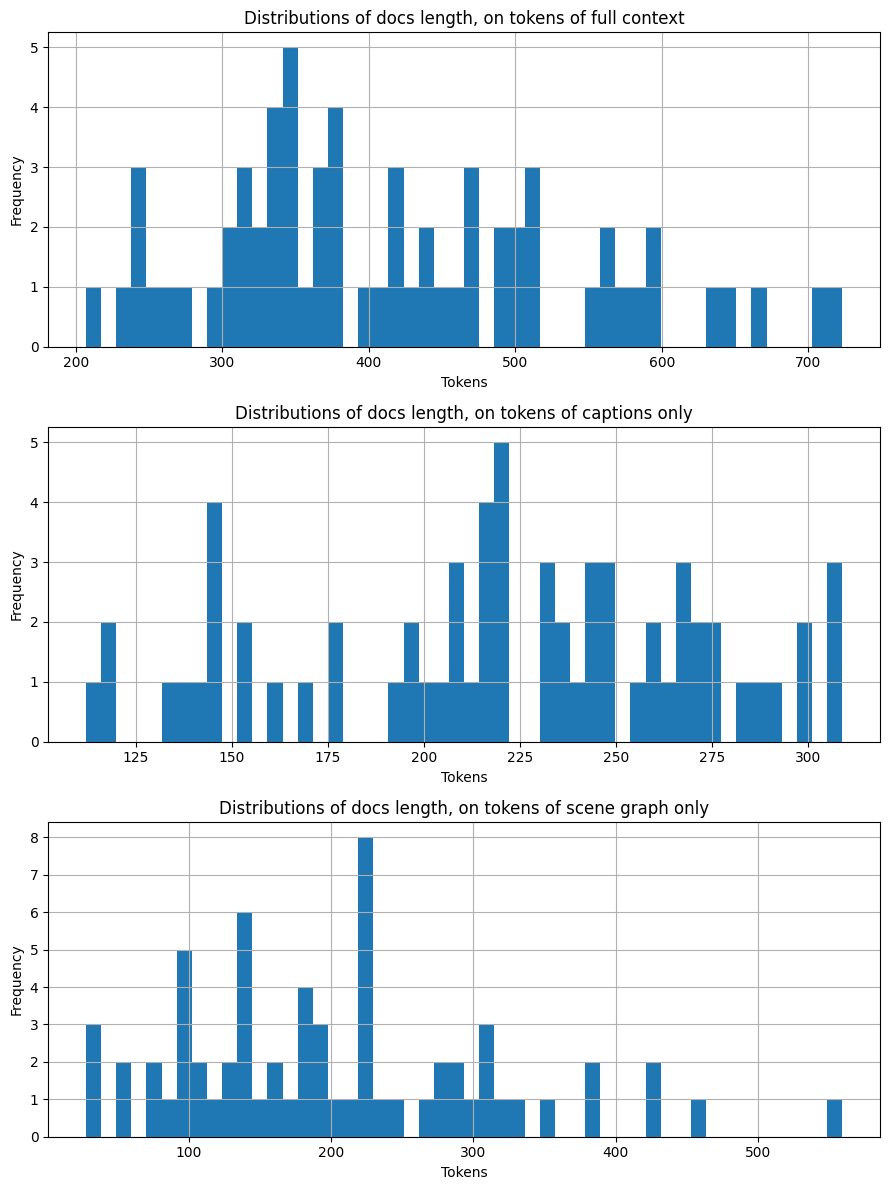

In [8]:
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Инициализируйте токенайзер
MODEL_NAME = 'thenlper/gte-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Функция для вычисления длин документов
def calculate_lengths(data):
    return [len(tokenizer.encode(text)) for text in tqdm(data)]

# Вычислите длины для каждого датасета
lengths_ddf = calculate_lengths(ddf)
lengths_ddf_c = calculate_lengths(ddf_c)
lengths_ddf_g = calculate_lengths(ddf_g)

# Создайте фигуру и массив осей (ax1, ax2, ax3)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

# Гистограмма для ddf
pd.Series(lengths_ddf).hist(bins=50, ax=ax1)
ax1.set_title("Distributions of docs length, on tokens of full context")
ax1.set_xlabel("Tokens")
ax1.set_ylabel("Frequency")

# Гистограмма для ddf_c
pd.Series(lengths_ddf_c).hist(bins=50, ax=ax2)
ax2.set_title("Distributions of docs length, on tokens of captions only")
ax2.set_xlabel("Tokens")
ax2.set_ylabel("Frequency")

# Гистограмма для ddf_g
pd.Series(lengths_ddf_g).hist(bins=50, ax=ax3)
ax3.set_title("Distributions of docs length, on tokens of scene graph only")
ax3.set_xlabel("Tokens")
ax3.set_ylabel("Frequency")

# Показать гистограммы
plt.tight_layout()
plt.show()


In [9]:
# Creating docs, without chunk splitting, because of lossing context
from langchain.docstore.document import Document as LangchainDocument

# All three types of approaches
docs_processed_full = [LangchainDocument(page_content=text) for text in ddf]
docs_processed_captions = [LangchainDocument(page_content=text) for text in ddf_c]
docs_processed_graph = [LangchainDocument(page_content=text) for text in ddf_g]

# Building vector database

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

KNOWLEDGE_VECTOR_DATABASE_FULL = FAISS.from_documents(
    docs_processed_full, embedding_model, distance_strategy=DistanceStrategy.COSINE
)
KNOWLEDGE_VECTOR_DATABASE_CAPTIONS = FAISS.from_documents(
    docs_processed_captions, embedding_model, distance_strategy=DistanceStrategy.COSINE
)
KNOWLEDGE_VECTOR_DATABASE_GRAPH = FAISS.from_documents(
    docs_processed_graph, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

/tmp/ipykernel_336641/486970415.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# Embed a user query in the same space
user_query = "Find me a bottle of water. Give me an image ID to it. Also write a reasoning, why you choose this image"
query_vector = embedding_model.embed_query(user_query)

In [13]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d_full = [
    list(KNOWLEDGE_VECTOR_DATABASE_FULL.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed_full))
] + [query_vector]
embeddings_2d_captions = [
    list(KNOWLEDGE_VECTOR_DATABASE_CAPTIONS.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed_captions))
] + [query_vector]
embeddings_2d_graph = [
    list(KNOWLEDGE_VECTOR_DATABASE_GRAPH.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed_graph))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected_full = embedding_projector.fit_transform(
    np.array(embeddings_2d_full), init="pca"
)
documents_projected_captions = embedding_projector.fit_transform(
    np.array(embeddings_2d_captions), init="pca"
)
documents_projected_graph = embedding_projector.fit_transform(
    np.array(embeddings_2d_graph), init="pca"
)

## Retrieving most relevant document

In [14]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs_full = KNOWLEDGE_VECTOR_DATABASE_FULL.similarity_search(query=user_query, k=5)
retrieved_docs_captions = KNOWLEDGE_VECTOR_DATABASE_CAPTIONS.similarity_search(query=user_query, k=5)
retrieved_docs_graph = KNOWLEDGE_VECTOR_DATABASE_GRAPH.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs_full[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs_full[0].metadata)


Starting retrieval for user_query='Find me a bottle of water. Give me an image ID to it. Also write a reasoning, why you choose this image'...

==================================Top document==================================
Image ID is 00291.
Here is the short description of it: 
The image shows an interior space that appears to be a hallway or corridor. The floor is carpeted in a dark gray color, and the walls are painted white. On the left side of the image, there is a white wall with several small, rectangular objects mounted on it, which could be light switches or thermostats. The right side of the image features a large, white door with a glass panel, through which a glimpse of a room with a window can be seen. The door is closed.

In the foreground, there is a blue water jug placed on the floor, which is partially obscured by the reflection of the door in the glass. The reflection creates a mirror-like effect, making it difficult to discern the exact position of the jug. The ov

## Top k documents

In [15]:
for doc_top_i, doc in enumerate(retrieved_docs_full):
    print(
    f"\n================================== Document #{doc_top_i} =================================="
    )
    print(doc.page_content)
    print("====================================================================")


================================== Document #0 ==================================
Image ID is 00291.
Here is the short description of it: 
The image shows an interior space that appears to be a hallway or corridor. The floor is carpeted in a dark gray color, and the walls are painted white. On the left side of the image, there is a white wall with several small, rectangular objects mounted on it, which could be light switches or thermostats. The right side of the image features a large, white door with a glass panel, through which a glimpse of a room with a window can be seen. The door is closed.

In the foreground, there is a blue water jug placed on the floor, which is partially obscured by the reflection of the door in the glass. The reflection creates a mirror-like effect, making it difficult to discern the exact position of the jug. The overall lighting in the space is bright, with natural light coming from the window on the right, which is not visible in the image. The style of 

In [16]:
from huggingface_hub import notebook_login

notebook_login()

# Reader LLM

In [17]:
READER_MODEL_NAME = "meta-llama/Llama-2-70b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

## Answer without using RAG

In [18]:
simple_answer = READER_LLM(user_query)
print(simple_answer[0]['generated_text'])

.

I'm not able to provide you with a physical bottle of water or an image ID, but I can suggest a few images that represent a bottle of water and explain why I chose them.

1. Image 1: A clear plastic bottle filled with water, with a white label and a black cap. The bottle is placed on a white background, and the lighting highlights the refraction of the water inside.

Reasoning: This image was chosen because it showcases a clean and simple design, which makes it easy to recognize the object as a bottle of water. The use of a white background and good lighting helps to emphasize the transparency and purity of the water inside.

2. Image 2: A glass bottle filled with water, with a wooden stopper and a tag attached to the neck. The bottle is placed on a rustic wooden table, surrounded by various fruits and herbs.

Reasoning: This image was chosen because it evokes a sense of naturalness and sustainability. The use of a glass bottle and a wooden stopper gives a more eco-friendly feel, wh

### It is clear, that LLM doesn't understand the context and what ID I'm talking about

# Prompt

In [20]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<s>[INST] <<SYS>>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.
<</SYS>>

Context:
{context}
---
Now here is the question you need to answer.

Question: {question} [/INST]


In [21]:
retrieved_docs_text_full = [
    doc.page_content for doc in retrieved_docs_full
]
retrieved_docs_text_captions = [
    doc.page_content for doc in retrieved_docs_captions
]
retrieved_docs_text_graph = [
    doc.page_content for doc in retrieved_docs_graph
]
# We only need the text of the documents

context_full = "\nExtracted documents:\n"
context_full += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text_full)]
)
context_captions = "\nExtracted documents:\n"
context_captions += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text_captions)]
)
context_graph = "\nExtracted documents:\n"
context_graph += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text_graph)]
)

final_prompt_full = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context_full
)
final_prompt_captions = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context_captions
)
final_prompt_graph = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context_graph
)

# Redact an answer
answer = READER_LLM(final_prompt_full)[0]["generated_text"]
print(answer)

  Image ID: 01146

Reasoning:
I chose this image because it contains a clear and visible representation of a bottle of water. The bottle is placed on the floor, next to a chair, and is easily recognizable due to its distinct shape and color. Additionally, the image is well-lit, providing a clear view of the bottle, and the surrounding environment is relatively clutter-free, making it easy to locate the bottle. Therefore, Image ID 01146 is the most suitable choice for finding a bottle of water.


In [22]:
df = pd.read_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs_with_responses.csv')

In [25]:
image_id = "01146"
mask = df['image_path'].str.contains(image_id)
#index of image of the response
row_index = int(df.index[mask].tolist()[0])
img = df.loc[row_index]

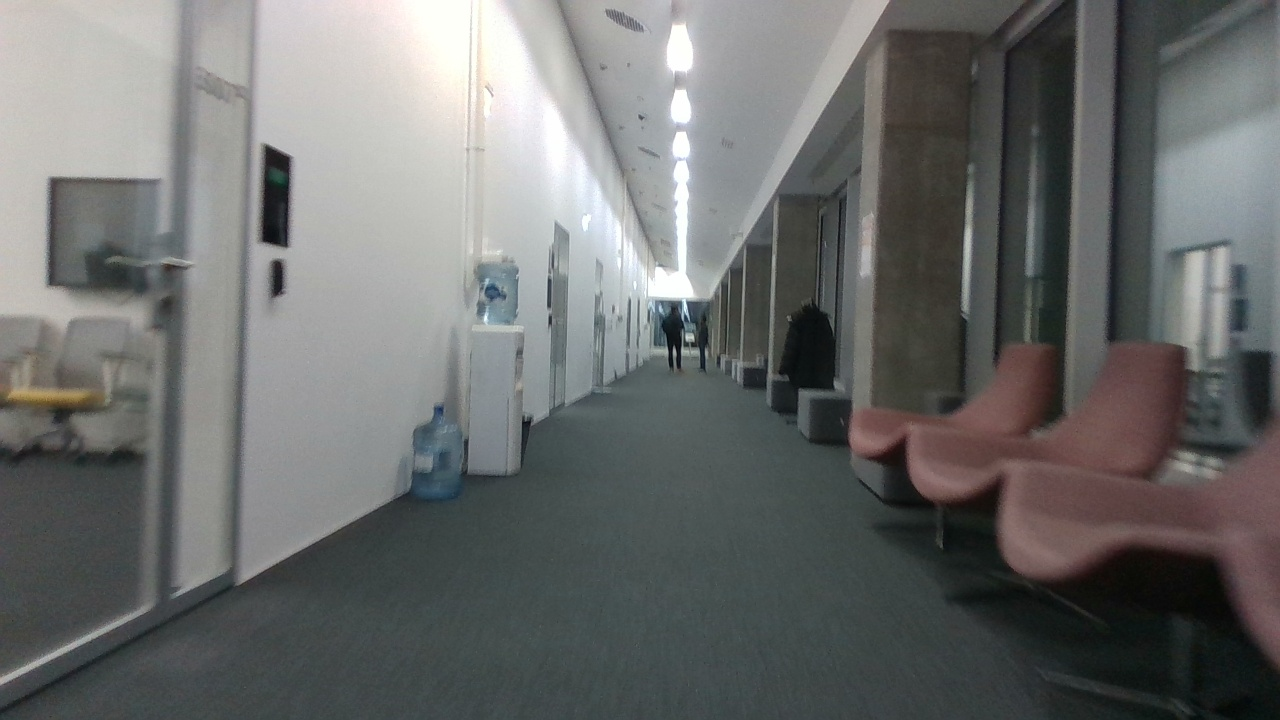

The image shows an interior hallway with a long, narrow layout. The floor is carpeted in a dark color, and the walls are painted white. On the left side of the hallway, there is a door with a glass panel and a metal frame. Above the door, there is a sign with the word "ELEVATOR" in green letters on a white background.

In the center of the hallway, there is a row of chairs with a modern design, featuring a mix of pink and gray colors. The chairs are arranged in a straight line, facing the same direction.

On the right side of the hallway, there is a person walking away from the camera, wearing dark clothing. The person appears to be carrying a bag.

The hallway is illuminated by overhead lights, and there is a reflection of the person and the chairs visible on the glass door. The overall atmosphere of the hallway is quiet and empty, with no other people visible in the image.


{'person_1': [[661, 304, 686, 373]], 'bottle_1': [[411, 403, 464, 501]], 'chaise_longue_1': [[847, 342, 1060, 

In [26]:
import PIL

image = PIL.Image.open("/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/"+image_id+".jpg")
image.show()

print(img.output)
print('\n')
print(img.scene_graph)
print('\n')
print(img.gpt_prompt)
print('\n')
print(img.gpt_response)

# Reranking

In [28]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [30]:
answer_full, relevant_docs_full = answer_with_rag(
    user_query, READER_LLM, KNOWLEDGE_VECTOR_DATABASE_FULL, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.49it/s]

=> Generating answer...


In [31]:
print("==================================Answer==================================")
print(f"{answer_full}")

print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs_full):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
  Based on the given context, I would recommend Image ID 00466 as the most likely image to contain a bottle of water.

The reasoning behind this choice is that the image depicts an interior space that appears to be a corridor or hallway, and it contains several key objects, including a blue water jug, which is visible near the doorway on the right side of the image. The presence of a water jug in the scene suggests that there may be a bottle of water nearby, and the fact that the jug is blue increases the likelihood that it contains water rather than another liquid. Additionally, the overall atmosphere of the image is calm and orderly, which suggests that the objects in the scene are likely to be in their intended places, making it more likely that the bottle of water is nearby.

Therefore, based on these observations, I recommend Image ID 00466 as the most likely image to contain a bottle of water.
============

In [32]:
image_id = "00466"
mask = df['image_path'].str.contains(image_id)
#index of image of the response
row_index = int(df.index[mask].tolist()[0])
img = df.loc[row_index]

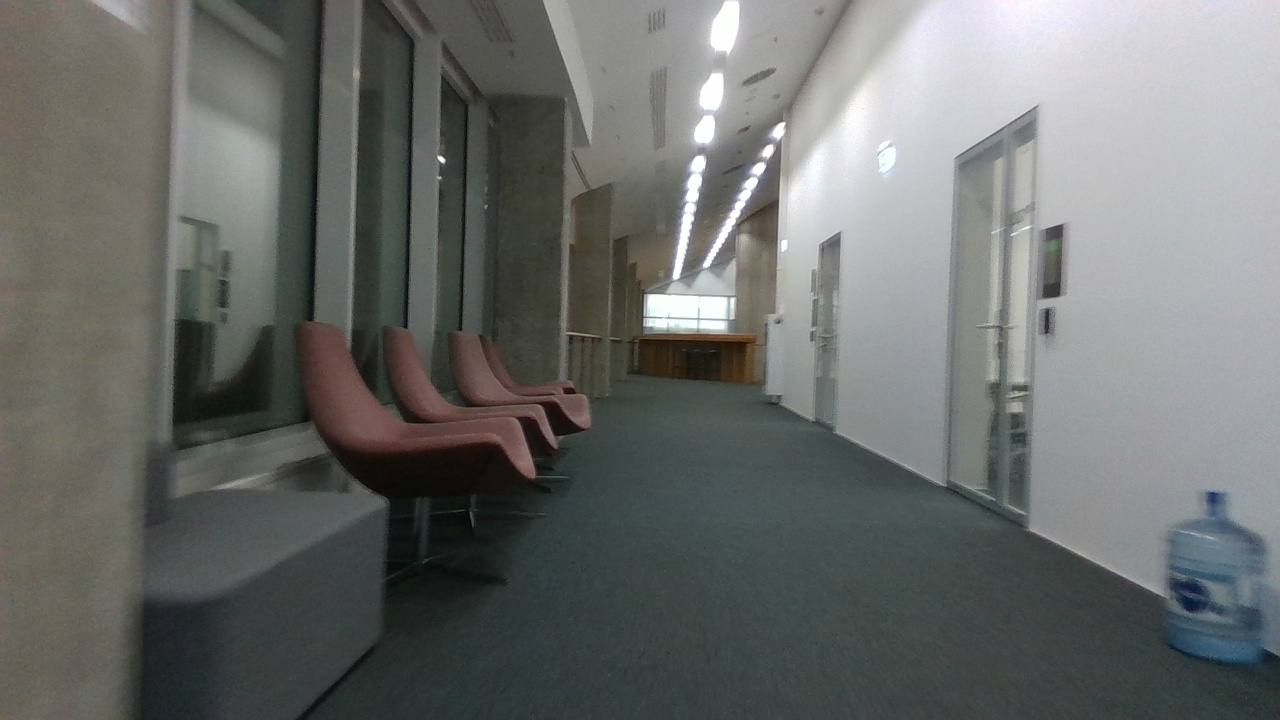

The image shows an interior space that appears to be a corridor or hallway. There are several key objects in the scene:

1. A row of six pink chairs lined up against a wall on the left side of the image. The chairs are arranged in a straight line, facing the same direction.
2. A gray bench is situated on the left side of the image, in front of the chairs.
3. A large window with multiple panes is on the left side of the image, allowing natural light to enter the space.
4. A doorway is visible on the right side of the image, leading to another room or area.
5. The floor is covered with a dark gray carpet, and the walls are painted white.
6. There is a blue water jug on the right side of the image, near the doorway.

The space seems to be well-lit and clean, with no visible obstacles or clutter. The overall atmosphere is calm and orderly.


{'chair_1': [[295, 320, 541, 585]], 'bottle_1': [[1164, 491, 1268, 667]], 'chair_2': [[447, 332, 592, 440]], 'chair_3': [[380, 324, 559, 462]], 'chair

In [33]:
image = PIL.Image.open("/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/"+image_id+".jpg")
image.show()

print(img.output)
print('\n')
print(img.scene_graph)
print('\n')
print(img.gpt_prompt)
print('\n')
print(img.gpt_response)